In [994]:
from __future__ import division

import numpy as np
import scipy as scp
import pylab as pyl
import matplotlib.pyplot as plt
from PIL import Image

from nt_toolbox.general import *
from nt_toolbox.signal import *

from scipy.misc import imread,imresize,imrotate, toimage, fromimage

from numpy import random
from copy import copy
from numpy import linalg

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### NL-means

In [995]:
def gradient_magnitude(im):
    [H, L] = im.shape
    im0 = copy(im)
    col = np.zeros((H, 1))
    lin = np.zeros((1, L))
    imcolp = np.concatenate((im0, col), 1)
    imlinp = np.concatenate((im0, lin), 0)
    imcoln = np.concatenate((col, im0), 1)
    imlinn = np.concatenate((lin, im0), 0)
    diff = np.sqrt((imcolp[0:H, 1:L +1] - imcoln[0:H, 0:L])**2 + 
                   (imlinp[1: H+1, 0:L]-imlinn[0:H,0:L])**2)
    return diff

def gradient_orientation(im):
    [H, L] = im.shape
    im0 = copy(im)
    col = np.zeros((H, 1))
    lin = np.zeros((1, L))
    imcolp = np.concatenate((im0, col), 1)
    imlinp = np.concatenate((im0, lin), 0)
    imcoln = np.concatenate((col, im0), 1)
    imlinn = np.concatenate((lin, im0), 0)
    ori = np.arctan2((imcolp[0:H, 1:L +1] - imcoln[0:H, 0:L]), 
                   (imlinp[1: H+1, 0:L]-imlinn[0:H,0:L]))
    return ori

In [996]:
def generate_patches(f, w):
    #location of pixels to extract

    (H, L) = f.shape
    [X,Y,dX,dY] = np.meshgrid(np.arange(1,L+1),np.arange(1,H+1),np.arange(-w,w+1),np.arange(-w,w+1))
    X = X + dX
    Y = Y + dY

    #boundary conditions
    X[X < 1] = 2-X[X < 1] 
    Y[Y < 1] = 2-Y[Y < 1]
    X[X > H] = 2*H-X[X > H]
    Y[Y > L] = 2*L-Y[Y > L]

    #patch extractor operator
    I = (X-1) + (Y-1)*H
    for i in range(H//w):
        for j in range(L//w):
            I[i,j] = np.transpose(I[i,j])

    def patch(f):
        return np.ravel(f)[I]
        
    return patch(f)

### Orientation and gradient magnitude

In [997]:
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]
  

def gaussian_kernel(w, sigma = 'auto'):
    if sigma == 'auto':
        sigma = w/1.5
    x = np.linspace(-w, w, 2*w + 1)
    y = np.linspace(-w, w, 2*w + 1)
    X, Y = np.meshgrid(x, y)
    Z = np.exp(-(X**2 + Y**2)/(2*sigma**2))
    return Z

def assign_orientation(P_orientation, P_magnitude, s, N):
    '''
    Assigns the principal orientation to each of the n*n patches in the image
    patch size: w_loc*w_loc
    Inputs: -Patch_orientation: set of the gradient 
                orientation of each patch [n,n,w_loc, w_loc]
            -Patch_gradient: set of the gradient magnitude of each patch
                [n,n,w_loc, w_loc]
            -s smoothing parameter for the gradient magnitude (float)
            -N quantization of the historgam of angles (int)
    Output: principal orientation of each patch [n,n]
    
    '''
    #Assigning angle to histogram bin
    orientation_bin = ((P_orientation+np.pi)*N/np.pi)//2
    #Initialisation
    [H, L, w_loc, w_loc] = P_orientation.shape
    histo = np.zeros((H, L, N))
    histo_weight = np.zeros((H, L, N))
    kern = gaussian_kernel(w_loc//2)
    #Give more weight to patch's center pixels
    P_magnitude = P_magnitude * kern
    
    #Generation of the histogram and weighted histogram
    for i in range(N):
        index_bin_i = orientation_bin == i
        histo[:,:,i] = np.count_nonzero(index_bin_i, (2,3))
        mag_copy = copy(P_magnitude)
        mag_copy[orientation_bin != i]=0
        histo_weight[:,:,i] = np.sum(mag_copy, axis = (2, 3))
        
    #smoothing the histogram by 6 circular convolutions
    for i in range(6):
        histo_weight = cconv(histo_weight, [1/3,1/3,1/3], 2)
        
    #extraction of the reference orientations
    theta = np.zeros((n,n))
    maxi = np.max(histo_weight, 2)
    for i in range(N):
        h = histo_weight[:,:,i]
        h_plus = histo_weight[:,:,(i+1)%N] 
        h_minus = histo_weight[:,:,(i-1)%N]
        d = h == maxi
        theta = np.maximum((360*(i+1/2)/N + 180/N * ((h_minus - h_plus)/(h_minus - 2*h + h_plus)))*d, theta)

    return theta

def generate_patches_oriented(f, w, N):
    #location of pixels to extract
    ori = gradient_orientation(f)
    mag = gradient_magnitude(f)
    w_aug = int(w*1.7)

    (H, L) = f.shape
    [X,Y,dX,dY] = np.meshgrid(np.arange(1,L+1),np.arange(1,H+1),np.arange(-w_aug,w_aug+1),np.arange(-w_aug,w_aug+1))
    X = X + dX
    Y = Y + dY

    #boundary conditions
    X[X < 1] = 2-X[X < 1] 
    Y[Y < 1] = 2-Y[Y < 1]
    X[X > H] = 2*H-X[X > H]
    Y[Y > L] = 2*L-Y[Y > L]

    #patch extractor operator
    I = (X-1) + (Y-1)*H
    for i in range(H//w_aug):
        for j in range(L//w_aug):
            I[i,j] = np.transpose(I[i,j])

    def patch_orientation(f):
        return np.ravel(ori)[I]
    def patch_magnitude(f):
        return np.ravel(mag)[I]
            
    P_orientation = patch_orientation(f)
    P_magnitude = patch_magnitude(f)
    
    princip_ori = assign_orientation(P_orientation, P_magnitude, w_aug, N)
    P = generate_patches(f, w_aug)

    patchprime = np.zeros((H, L, 2*w + 1, 2*w + 1))
    
    #print(patchprime.shape)
    for i in range(H):
        for j in range(L):
            #patchprime[i,j, :,:] = crop_center(imrotate(P[i,j,:,:],0*10 * princip_ori[i,j],'bilinear'), 
            #                                   2*w + 1, 2*w + 1)
            #patchprime[i,j, :,:] = crop_center(rotate_image(P[i,j,:,:], 10 * princip_ori[i,j] * np.pi/180,w_aug,w_aug), 
             #                                  2*w + 1, 2*w + 1)
            patchprime[i,j,:,:] = crop_center(scp.ndimage.interpolation.rotate(
                P[i,j,:,:],princip_ori[i,j], axes=(1, 0), reshape=False,
                output=None, order=3, mode='constant', cval=0.0, prefilter=True),
                                              2*w + 1, 2*w + 1)
            #patchprime[i,j, :,:] = crop_center(P[i,j,:,:], 2*w + 1, 2*w + 1)
    #plt.figure()
    #plt.imshow(patchprime[40, 50])
    #print(patchprime[40, 50])
    patchprime = patchprime.astype(np.float)
    
    return patchprime

In [998]:
def PCA_patch(P):
    [H, L, w1, w1] = P.shape
    #Turn the patch matrix into an (w1∗w1,n∗n)(w1∗w1,n∗n) array, so that each P(:,i)P(:,i) 
    #is a w1∗w1w1∗w1 vector representing a patch
    resh = lambda P: np.transpose((np.reshape(P, (H*L,w1*w1), order="F")))
    #center each patch
    remove_mean = lambda Q: Q - np.tile(np.mean(Q,0),(w1*w1,1))
    #mean and covariance
    P1 = remove_mean(resh(P))
    C = np.dot(P1,np.transpose(P1))

    #Extract the eigenvectors, sorted by decreasing amplitude.
    [D,V] = linalg.eig(C)
    D = np.sort(D)[::-1]
    I = np.argsort(D)[::-1]
    V = V[I,:]
    return D, V

def dim_reduction(P, V, d):
    [H, L, w1, w1] = P.shape
    resh = lambda P: np.transpose((np.reshape(P, (H*L,w1*w1), order="F")))
    #patch dimensionality reduction operator
    iresh = lambda Q: np.reshape(np.transpose(Q),(H,L,d),order="F")
    remove_mean = lambda Q: Q - np.tile(np.mean(Q,0),(w1*w1,1))

    descriptor = lambda f: iresh(np.dot(np.transpose(V[: ,:d]),remove_mean(resh(P))))
    Dsc = descriptor(f)
    return Dsc, w1

In [1152]:
selection = lambda i: np.array((clamp(np.arange(i[0]-q,i[0] + q + 1), 0, H-1),
                                clamp(np.arange(i[1]-q,i[1] + q + 1), 0, L-1)))
normalize = lambda K: K/np.sum(K)

def distance(i, Dsc):
    sel = selection(i)
    Dsc1 = (Dsc[sel[0],:,:])
    Dsc2 = (Dsc1[:,sel[1],:])
    S = np.sum((Dsc2 - np.tile(Dsc[i[0],i[1],:],
                                  (len(sel[0]),len(sel[1]),1)))**2,2)/(w1*w1)
    return S

def kernel(i, tau, Dsc, P):
    
    var = np.std(P[i[0], i[1]])
    #print(np.exp(-distance(i)[20, 20]*var/ (2*tau**2)))
    #print(np.exp(-distance(i)[20, 20]*var**2/ (2*tau**2)))
    #print(np.exp(-distance(i)[20, 20]/ (var*2*tau**2)))
    #print(np.exp(-distance(i)[20, 20]*(-np.log(var)/ (2*tau**2))))

    alph = np.exp(-distance(i, Dsc)/ (2*tau**2*np.sqrt(var)))
    #print(alph)
    alph[q,q] = 0# np.exp(-2*sigma**2/(2*tau**2*w1*w1))
    alph[q,q] = np.max(alph)

    return normalize(alph)



def window_search(i, tau, q, Dsc, w1, P):
    [H, L, d] = Dsc.shape

    
    #index selection
    return kernel(i, tau, Dsc, P), selection(i)
    
    
#NL-filtered value
def NLval_0(K,sel): 
    f_temp = f[sel[0],:]
    return np.sum(K*f_temp[:, sel[1]])


def NL_means(f, w, q, d, tau, P = False, rotate = False, blur = 1, N=100, i = False):
    H, L = f.shape
    f_blur =  f#gaussian_blur(f, blur)

    if type(P) == bool:
        if rotate == True:
            P = generate_patches_oriented(f_blur, w, N)
        elif rotate == False:
            P = generate_patches(f_blur,w)
        else: 
            return 'rotate must be either True or False'
    D, V = PCA_patch(P)
    Dsc, w1 = dim_reduction(P, V, d)
    P_copy = copy(P)
    #apply NL-means
    [Y, X] = np.meshgrid(np.arange(0,H),np.arange(0,L))
    R = np.zeros([H,L])
   # print(tau, w, w1, q, d)
    for k in range(H):
        for l in range(L):
            K, sel = window_search([k,l], tau, q, Dsc, w1, P_copy)
            R[k,l] = NLval_0(K, sel)
            if [k,l]==i:
                Q = K
                sel_i = sel
                
                
    return R, Q, sel_i


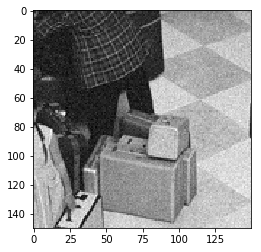

In [1153]:
n = 150
w = 5
w1 = 2*w + 1 #patch size
q = 14 #patch window
d = 25 #dimensionnality reduction
c = [80, 350]
tau = 0.02



f0 = load_image("nt_toolbox/data/airport.jpg")
f0 = rescale(f0[c[0]-n//2:c[0]+n//2, c[1]-n//2:c[1]+n//2])
sigma = .04 #noise level

f = f0 + sigma*random.standard_normal(f0.shape) #noisy image

def neighbors(f, i, w, q, d, tau, rotate = False, blur = 1, N = 100):
    H, L = f.shape
    f_blur = f#gaussian_blur(f, blur)
    if rotate == True:
        P = generate_patches_oriented(f_blur, w, N)
    elif rotate == False:
        P = generate_patches(f_blur,w)
    else: 
        return 'rotate must be either True or False'
    
    D, V = PCA_patch(P)
    Dsc, w1 = dim_reduction(P, V, d)

    #apply NL-means
    [Y, X] = np.meshgrid(np.arange(0,H),np.arange(0,L))
    R = []
    #print(tau, w, w1, q, d)
    K, sel = window_search(i, tau, q, Dsc, w1, P)
    #print(K[0,0])
    #imageplot(K)
    
    return K, sel, P, Dsc
plt.imshow(f, cmap = 'gray')


C:\Users\alien\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
C:\Users\alien\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in maximum
C:\Users\alien\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\alien\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
C:\Users\alien\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


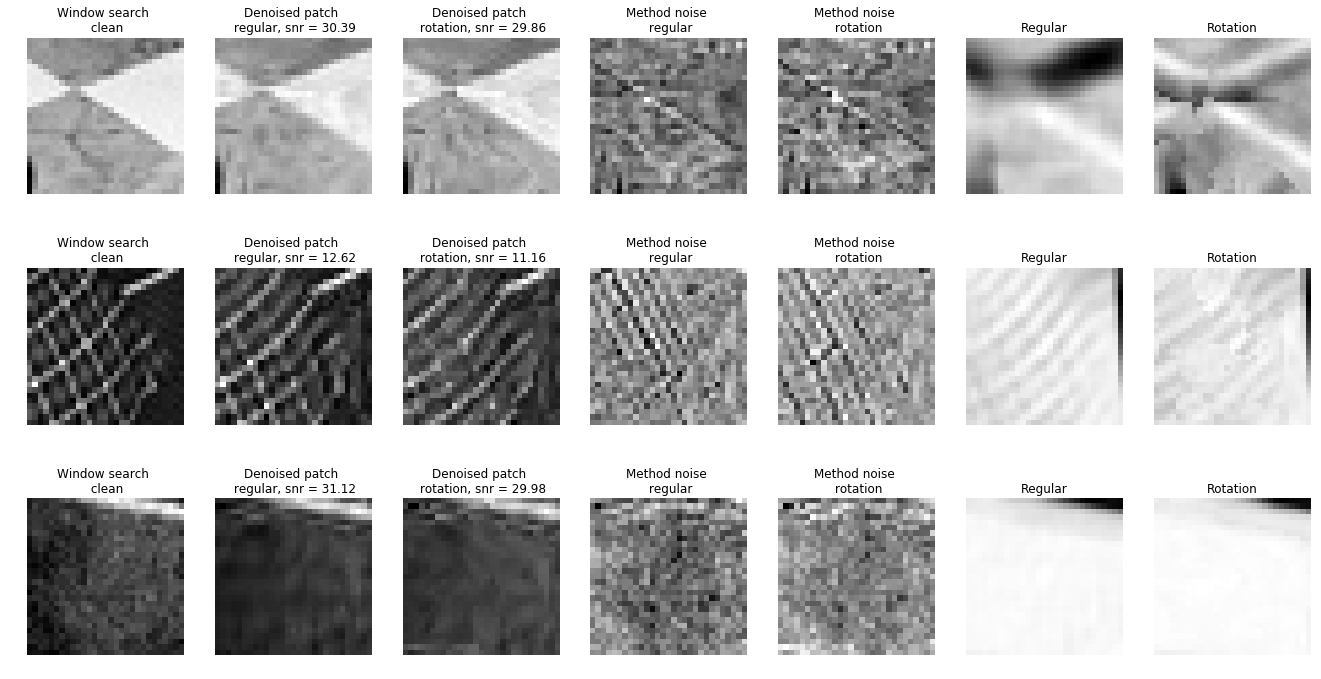

In [1154]:
plt.figure(figsize = (23, 12))

#i = [66, 120]#carreau
#i = [20, 70]#veste
i = [66, 120]
#imageplot(f, 'part of the image', [3,5,1])
def select_part(f, sel):
    f_temp = f[sel[0],:]
    f_temp = f_temp[:, sel[1]]
    return f_temp

H, L = f.shape
P_rot = generate_patches_oriented(f, w, N  = 200)
P_reg = generate_patches(f, w)

R_reg, Q_reg, sel_ireg = NL_means(f, w, q, d, tau, rotate = False, blur = 1, N=200, i= i)
R_rot, Q_rot, sel_irot = NL_means(f, w, q, d, tau,  rotate = True, blur = 1, N=200, i = i)

f_temp = select_part(f0, sel_ireg)
imageplot(f_temp, 'Window search \n clean', [3,7,1])visua

f_reg = select_part(R_reg, sel_ireg)
imageplot(f_reg, 'Denoised patch \n regular, snr = ' + str(round(snr(f_temp, f_reg),2)), [3, 7, 2 ])

f_rot = select_part(R_rot, sel_irot)
imageplot(f_rot, 'Denoised patch \n rotation, snr = ' + str(round(snr(f_temp, f_rot),2)), [3, 7, 3 ])

imageplot(f_reg - f_temp, 'Method noise \n regular', [3,7,4])
imageplot(f_rot - f_temp, 'Method noise \n rotation', [3,7,5])

P_reg_den = generate_patches(R_reg, w)
P_rot_den = generate_patches(R_rot, w)

#SNR_reg = select_part(snr_per_loc(f0, P_reg_den, w), sel_ireg)
#SNR_rot = select_part(snr_per_loc(f0, P_rot_den, w), sel_irot)

#imageplot(SNR_reg, 'Local SNR \n regular', [3,9,6])
#imageplot(SNR_rot, 'Local SNR \n regular', [3,9,7])


imageplot(np.log(Q_reg), 'Regular', [3,7,6])
imageplot(np.log(Q_rot), 'Rotation', [3,7,7])

i = [22, 70]

R_reg, Q_reg, sel_ireg = NL_means(f, w, q, d, tau,  rotate = False, blur = 1, N=200, i= i)
R_rot, Q_rot, sel_irot = NL_means(f, w, q, d, tau,  rotate = True, blur = 1, N=200, i = i)

f_temp = select_part(f0, sel_ireg)
imageplot(f_temp, 'Window search \n clean', [3,7,8])


f_reg = select_part(R_reg, sel_ireg)
imageplot(f_reg, 'Denoised patch \n regular, snr = ' + str(round(snr(f_temp, f_reg),2)) , [3, 7, 9 ])

f_rot = select_part(R_rot, sel_irot)
imageplot(f_rot, 'Denoised patch \n rotation, snr = ' + str(round(snr(f_temp, f_rot),2)), [3, 7, 10])

imageplot(f_reg - f_temp, 'Method noise \n regular', [3,7,11])
imageplot(f_rot - f_temp, 'Method noise \n rotation', [3,7,12])


#SNR_reg = select_part(snr_per_loc(f0, P_reg_den, w), sel_ireg)
#SNR_rot = select_part(snr_per_loc(f0, P_rot_den, w), sel_irot)

#imageplot(SNR_reg.T, 'Local SNR \n regular', [3,9,15])
#imageplot(SNR_rot.T, 'Local SNR \n regular', [3,9,16])


imageplot(np.log(Q_reg), 'Regular', [3,7,13])
imageplot(np.log(Q_rot), 'Rotation', [3,7,14])


i = [120,75]



R_reg, Q_reg, sel_ireg = NL_means(f, w, q, d, tau,  rotate = False, blur = 1, N=200, i= i)
R_rot, Q_rot, sel_irot = NL_means(f, w, q, d, tau,  rotate = True, blur = 1, N=200, i = i)

f_temp = select_part(f0, sel_ireg)
imageplot(f_temp, 'Window search \n clean', [3,7,15])

f_reg = select_part(R_reg, sel_ireg)
imageplot(f_reg, 'Denoised patch \n regular, snr = ' + str(round(snr(f_temp, f_reg),2)), [3, 7, 16 ])

f_rot = select_part(R_rot, sel_irot)
imageplot(f_rot, 'Denoised patch \n rotation, snr = ' + str(round(snr(f_temp, f_rot),2)), [3, 7, 17 ])

imageplot(f_reg - f_temp, 'Method noise \n regular', [3,7,18])
imageplot(f_rot - f_temp, 'Method noise \n rotation', [3,7,19])


SNR_reg = select_part(snr_per_loc(f0, P_reg_den, w), sel_ireg)
SNR_rot = select_part(snr_per_loc(f0, P_rot_den, w), sel_irot)

#imageplot(SNR_reg, 'Local SNR \n regular', [3,9,24])
#imageplot(SNR_rot, 'Local SNR \n regular', [3,9,25])


imageplot(np.log(Q_reg), 'Regular', [3,7,20])
imageplot(np.log(Q_rot), 'Rotation', [3,7,21])






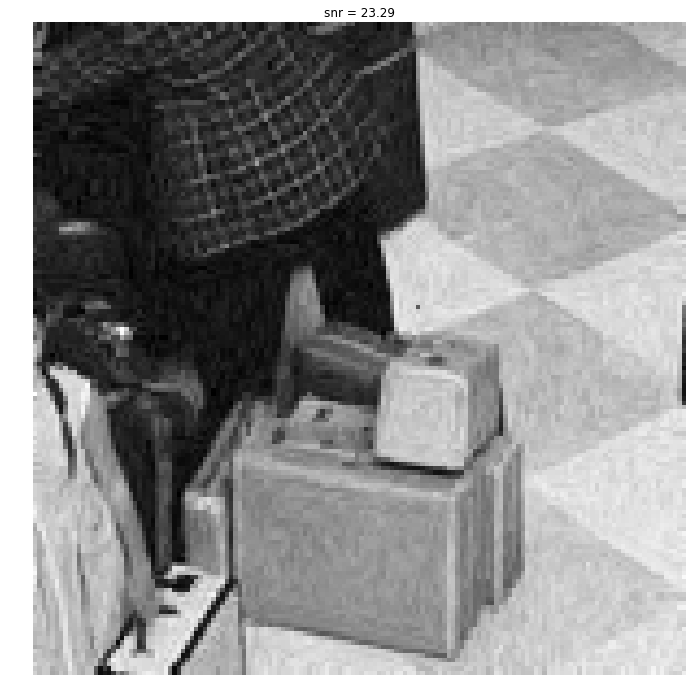

In [1142]:
plt.figure(figsize = (12,12))
imageplot(R_reg, 'snr = ' + str(round(snr(f0, R_reg), 2)))

In [918]:
a, b, c = NL_means(f, w, q, d, tau, P_rot, rotate = False, blur = 1, N=100)

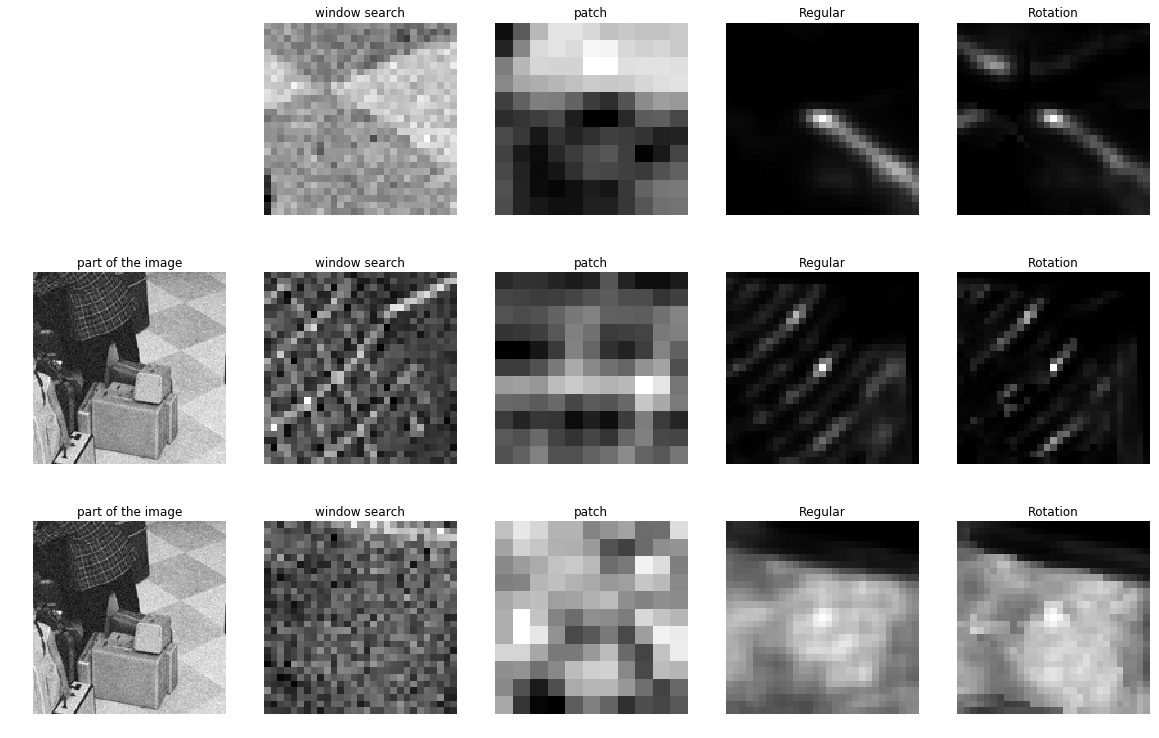

In [969]:
plt.figure(figsize = (20, 13))

#i = [66, 120]#carreau
#i = [20, 70]#veste
i = [66, 120]
#imageplot(f, 'part of the image', [3,5,1])


H, L = f.shape

f0 =f

K, sel, P, Dsc = neighbors(f0, i, w, q, d, tau, rotate = True, N=100)
imageplot(K, 'Rotation', [3,5,5])
K1, sel1, P1, Dsc1 = neighbors(f0, i, w, q, d, tau, rotate = False)
imageplot(K1, 'Regular', [3,5,4])


f_temp = f[sel1[0],:]
f_temp = f_temp[:, sel1[1]]
imageplot(f_temp, 'window search', [3,5,2])
imageplot(P[i[0],i[1]].T, 'patch', [3,5,3])

i = [20, 70]
imageplot(f, 'part of the image', [3,5,6])


H, L = f.shape

K, sel, P, Dsc = neighbors(f0, i, w, q, d, tau, rotate = True, N=100)
imageplot(K, 'Rotation', [3,5,10])
K1, sel1, P1, Dsc1 = neighbors(f0, i, w, q, d, tau, rotate = False)
imageplot(K1, 'Regular', [3,5,9])


f_temp = f[sel1[0],:]
f_temp = f_temp[:, sel1[1]]
imageplot(f_temp, 'window search', [3,5,7])
imageplot(P[i[0],i[1]].T, 'patch', [3,5,8])

i = [120,75]
imageplot(f, 'part of the image', [3,5,11])


H, L = f.shape

K, sel, P, Dsc = neighbors(f0, i, w, q, d, tau, rotate = True, N=100)
imageplot(K, 'Rotation', [3,5,15])
K1, sel1, P1, Dsc1 = neighbors(f0, i, w, q, d, tau, rotate = False)
imageplot(K1, 'Regular', [3,5,14])


f_temp = f[sel1[0],:]
f_temp = f_temp[:, sel1[1]]
imageplot(f_temp, 'window search', [3,5,12])
imageplot(P[i[0],i[1]].T, 'patch', [3,5,13])


C:\Users\alien\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


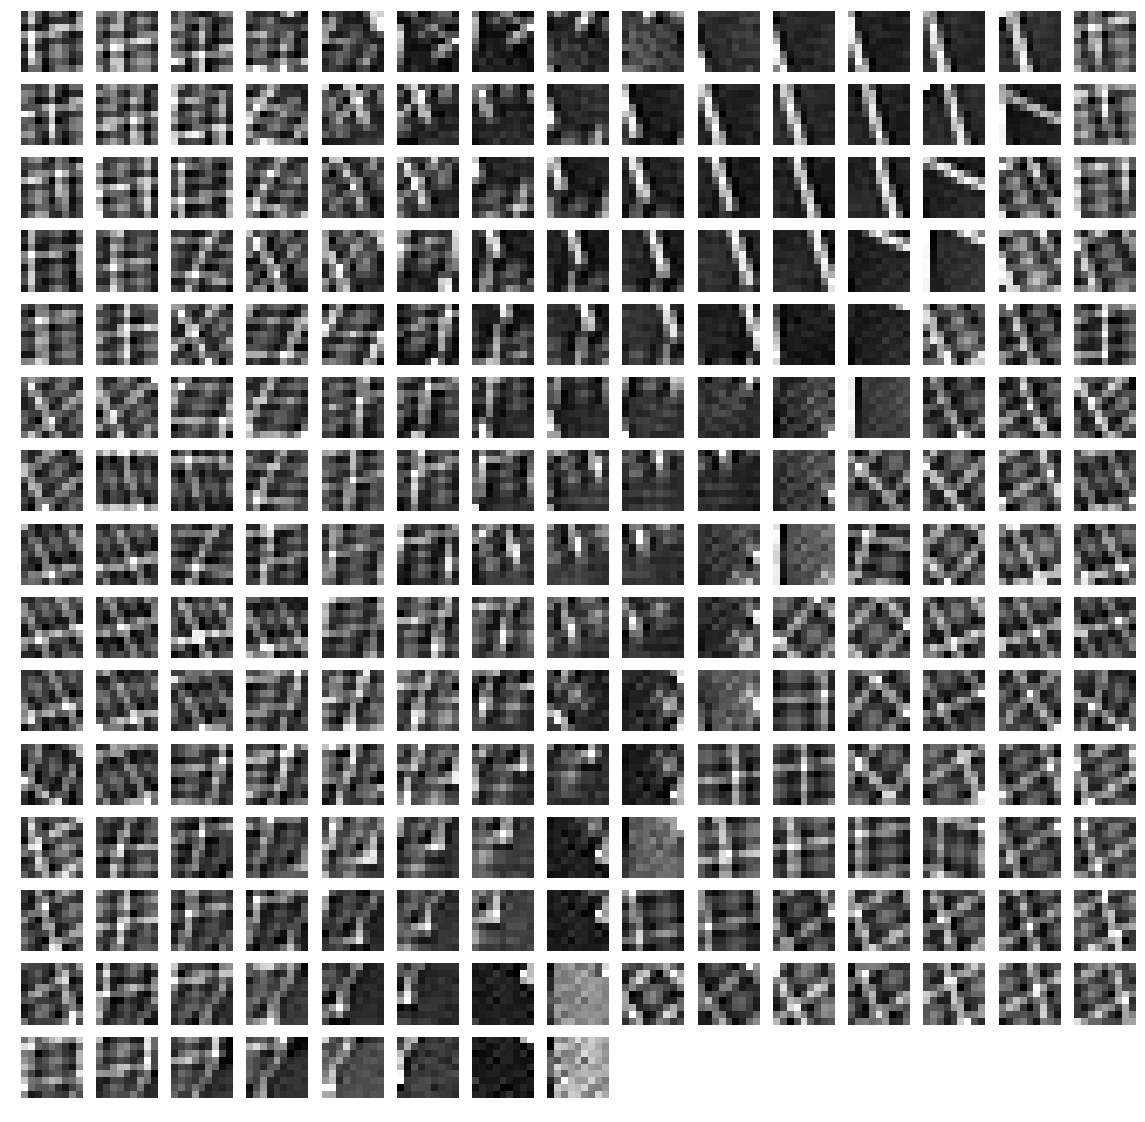

In [616]:
plt.figure(figsize = (20,20))
W = 2*q + 1


for i in range(W):
    if i%2 == 0:
        for j in range(W):
            if j%2 == 0:
                imageplot(P[sel[0][i], sel[1][j]], '', [W//2+1, W//2+1, W*i//4 + j//2 + 1])

C:\Users\alien\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


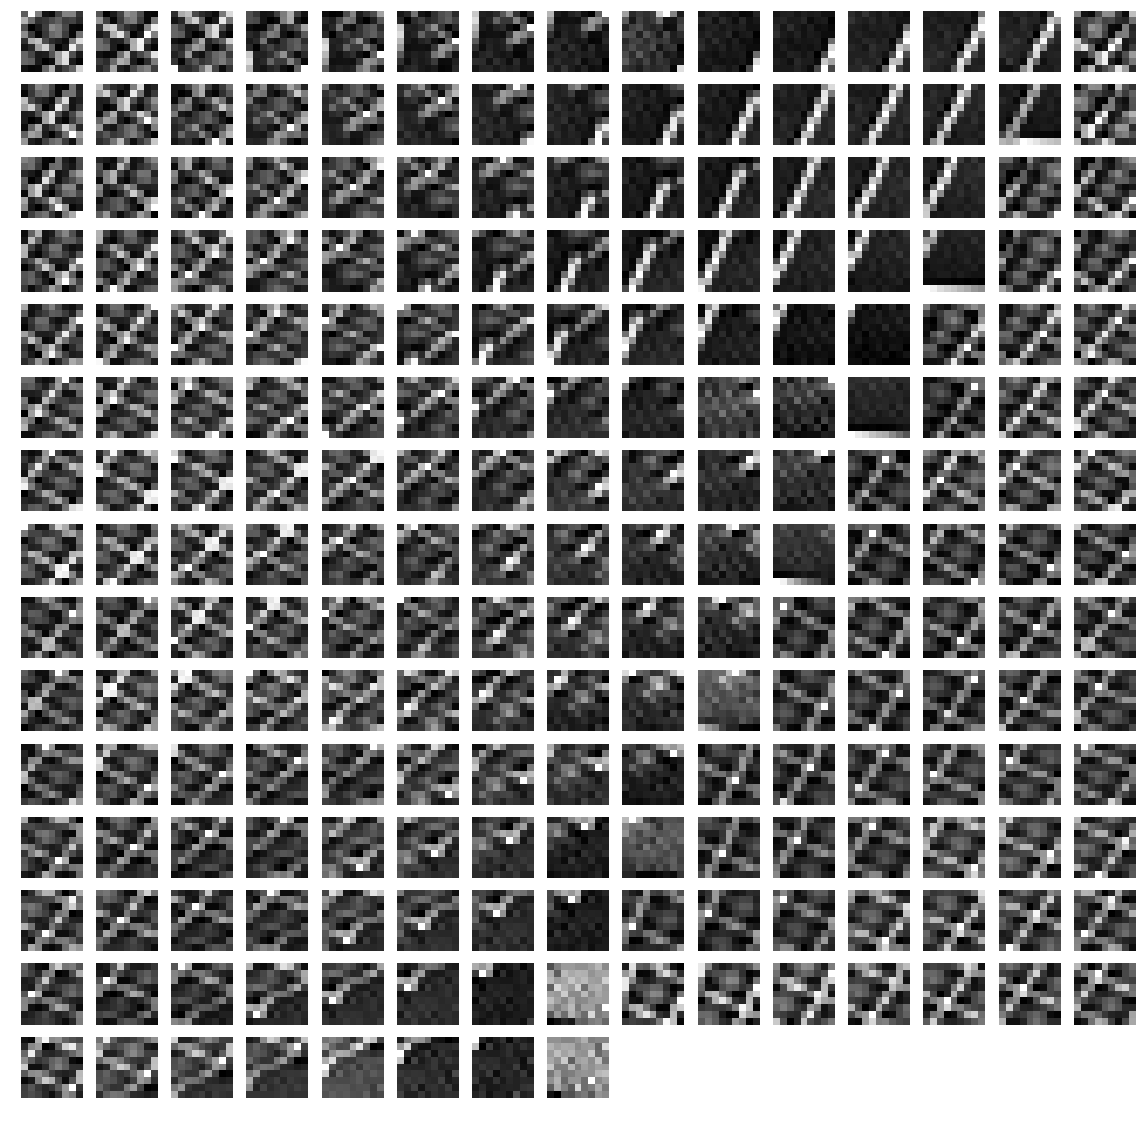

In [617]:
plt.figure(figsize = (20,20))
W = 2*q + 1


for i in range(W):
    if i%2 == 0:
        for j in range(W):
            if j%2 == 0:
                imageplot(P1[sel[0][i], sel[1][j]], '', [W//2+1, W//2+1, W*i//4 + j//2 + 1])

C:\Users\alien\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
C:\Users\alien\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in maximum


0.03 4 9 14 25
0.0009892679035033841
0.03 4 9 14 25
0.0009892679035033841


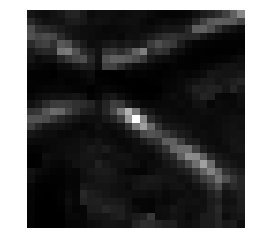

In [724]:
n = 150
w = 4
w1 = 2*w + 1 #patch size
q = 14 #patch window
d = 25 #dimensionnality reduction
c = [80, 350]
tau = 0.03
i = [66, 120]
h = NL_means(f, w, q, d, tau, rotate = True, blur = 0.01, N=100)
g = neighbors(f, i, w, q, d, tau, rotate = True, blur = 0.01, N = 100)

### Image initialisation

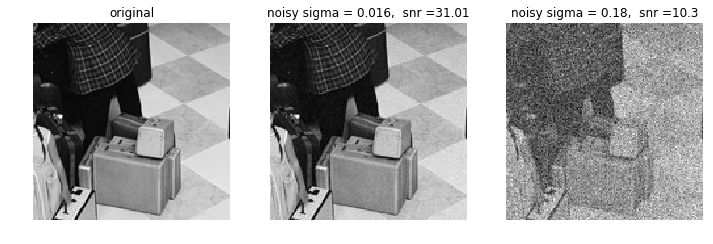

In [452]:
n = 150
w = 3
tau = 0.01
c = [80,350]
f0 = load_image("nt_toolbox/data/airport.jpg")
f0 = rescale(f0[c[0]-n//2:c[0]+n//2, c[1]-n//2:c[1]+n//2])
sigma = [0.016, 0.18] #noise level

plt.figure(figsize = (12,12))
imageplot(f0, 'original', [1,3,1])
for i in range(len(sigma)):
    f = f0 + sigma[i]*random.standard_normal(f0.shape) #noisy image

    imageplot(f, 'noisy sigma = ' + str(sigma[i])+',  snr =' + str(round(snr(f,f0),2)), [1,3,2+i])
#reg = NL_means(f, w, q, d, tau, rotate = False, N = 360)
#imageplot(reg, 'Regular NL-means, snr =' + str(round(snr(reg,f0),2)), [2, 2, 3])
#rot = NL_means(f, w, q, d, tau, rotate = True, N = 360)
#imageplot(rot, 'NL-means rotation, snr =' +  str(round(snr(rot,f0),2)), [2, 2, 4])




In [505]:
print(snr(f0, f))

30.216976245083305


### Test the patch size

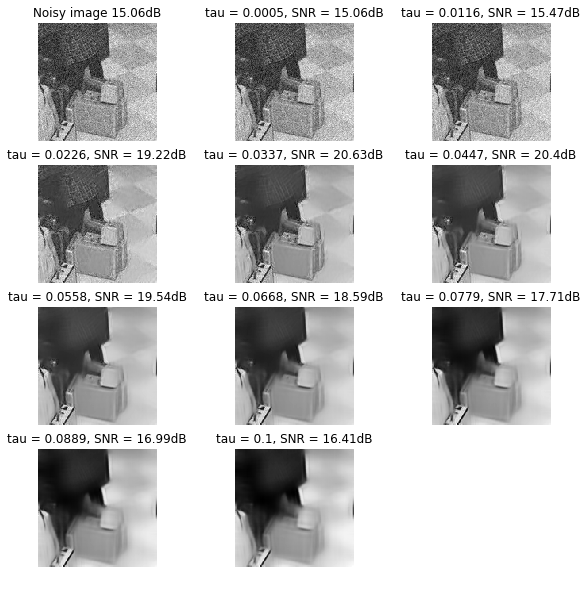

In [885]:
n = 150
w = 5
w1 = 2*w + 1 #patch size
q = 10 #patch window
d = 25 #dimensionnality reduction
c = [80, 350]
tau = np.linspace(0.0005, 0.1, 10)
SNR_rotate = []
SNR_regular = []
all_w = [2,3,4,5,7,9,11,13]

f0 = load_image("nt_toolbox/data/airport.jpg")
f0 = rescale(f0[c[0]-n//2:c[0]+n//2, c[1]-n//2:c[1]+n//2])
sigma = .1 #noise level

f = f0 + sigma*random.standard_normal(f0.shape) #noisy image
plt.figure(figsize = (10,10))
imageplot(f, 'Noisy image ' + str(round(snr(f0, f),2)) + 'dB', [(len(tau)+1)//3 +1, 3, 1])

for i in range(len(tau)):
    imout_rotate = NL_means(f, w, q, d, tau[i], rotate = True)
    err_rotate = round(snr(f0, imout_rotate),2)
    SNR_rotate.append(err_rotate)

    imout_regular = NL_means(f, w, q, d, tau[i], rotate = False)
    err_regular = round(snr(f0, imout_regular),2)        
    SNR_regular.append(err_regular)
    #if i%5 == 0:
    #imageplot(imout, 'tau = ' + str(round(tau[i], 4)) +', SNR = ' + str(err) + 'dB', [(len(tau)+1)//15 +1, 3, i//5+2])
    imageplot(imout_regular, 'tau = ' + str(round(tau[i], 4)) +', SNR = ' + str(err_regular) + 'dB', [(len(tau)+1)//3 +1, 3, i+2])


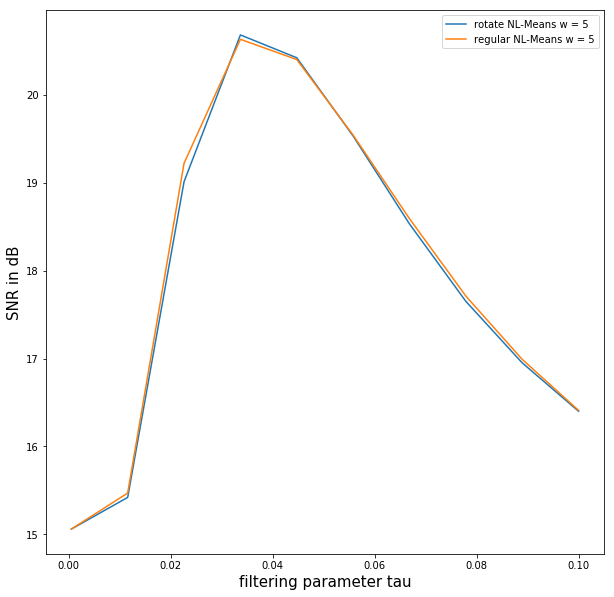

In [886]:
plt.figure(figsize = (10,10))
plt.plot(tau, SNR_rotate, label = 'rotate NL-Means w = %d' %w)

plt.plot(tau, SNR_regular, label = 'regular NL-Means w = %d' %w)
plt.xlabel('filtering parameter tau', fontsize = 15)
plt.ylabel('SNR in dB', fontsize = 15)
plt.legend()
plt.savefig('compare SNR filtering parameter sigma 0_1 w_10 airport2.jpg')

In [855]:
w = [5, 7, 11, 15, 21]
sn_rot = [23.7, 25.2, 25.8, 25.3, 24.5]
sn_reg = [23.5, 24.9, 25.85, 25, 24.2]
sn_reg

[23.5, 24.9, 25.85, 25, 24.2]

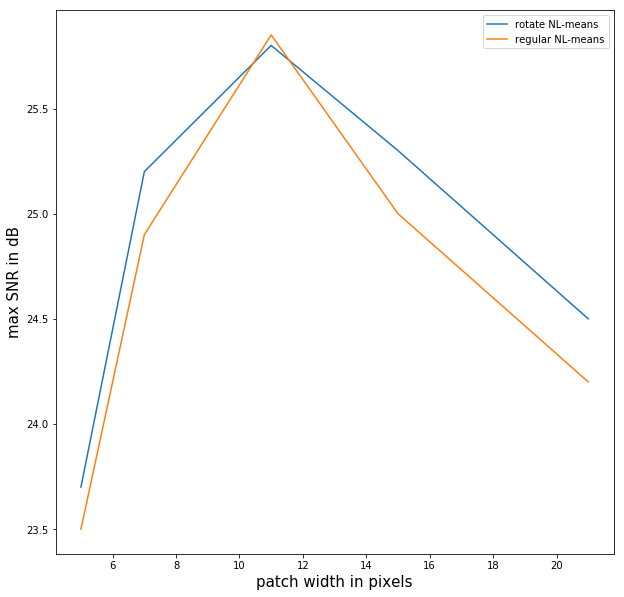

In [857]:
plt.figure(figsize = (10,10))
plt.plot(w, sn_rot, label = 'rotate NL-means')
plt.plot(w, sn_reg, label = 'regular NL-means')
plt.xlabel('patch width in pixels', fontsize = 15)
plt.ylabel('max SNR in dB', fontsize = 15)
plt.legend()

C:\Users\alien\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
C:\Users\alien\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in maximum
C:\Users\alien\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\alien\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
C:\Users\alien\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


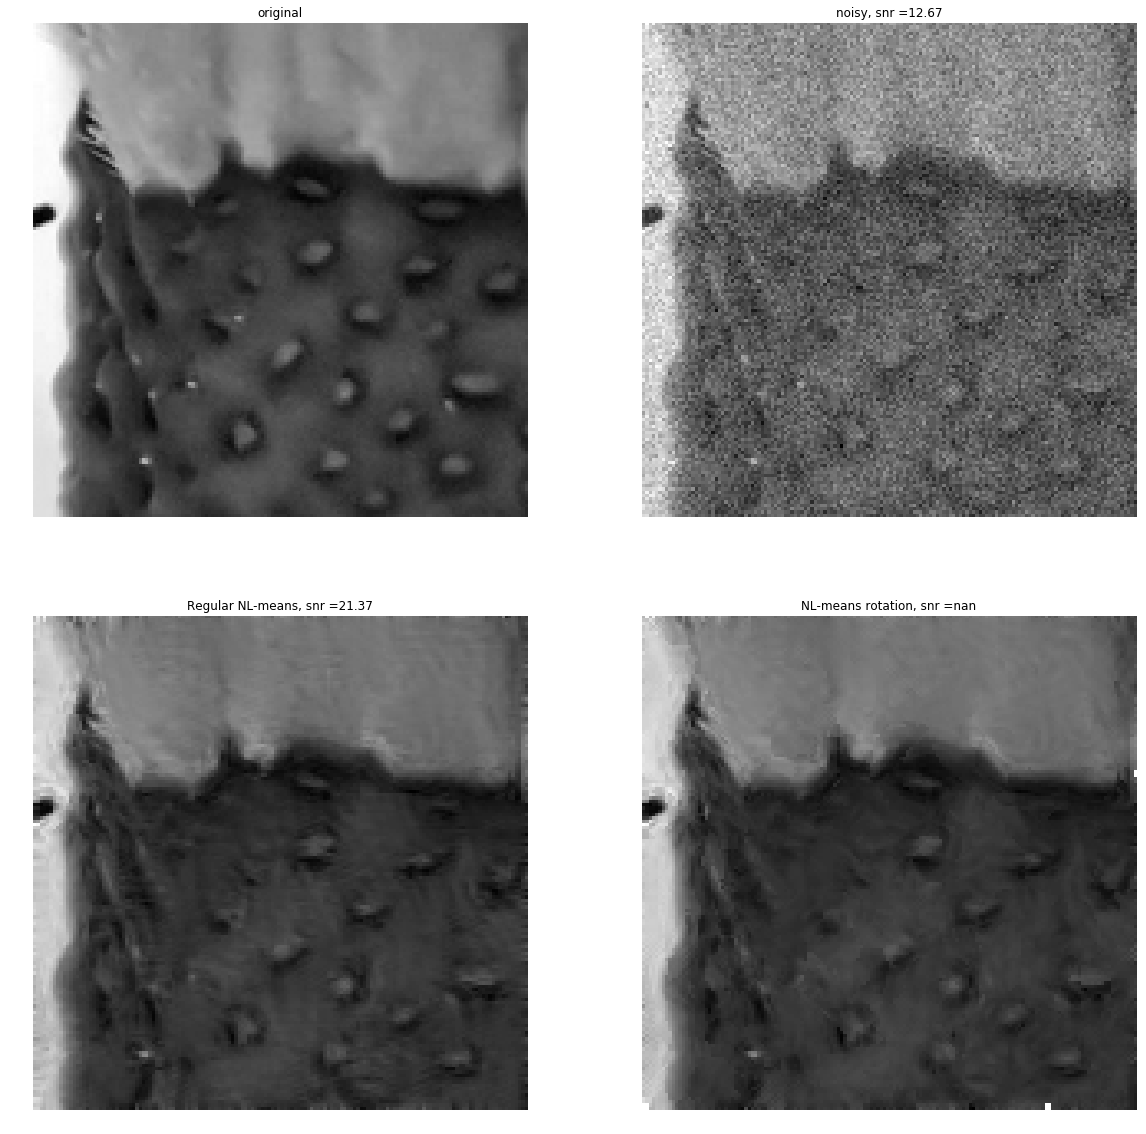

In [1189]:
n = 150
w = 5
w1 = 2*w + 1 #patch size
q = 10 #patch window
d = 25 #dimensionnality reduction
c = [500, 500]
f0 = load_image("nt_toolbox/data/bee.png")
f0 = rescale(f0[c[0]-n//2:c[0]+n//2, c[1]-n//2:c[1]+n//2])
sigma = .1 #noise level
f = f0 + sigma*random.standard_normal(f0.shape) #noisy image
tau = 0.04

i = [20,60]

H=n
L=n

plt.figure(figsize = (20,20))

R_reg, Q_reg, sel_ireg = NL_means(f, w, q, d, tau, rotate = False, blur = 1, N=200, i = i)
R_rot, Q_rot, sel_irot = NL_means(f, w, q, d, tau,  rotate = True, blur = 1, N=200, i = i)
#reg2, a, b = NL_means(f, w, q, d, tau, rotate = False, i = i) #tau[np.argmax(SNR_regular)]
#rot2, a, b = NL_means(f, w, q, d, tau, rotate = True, i = i, N = 100)

imageplot(f0, 'original', [2,2,1])
imageplot(f, 'noisy, snr =' + str(round(snr(f,f0),2)), [2,2,2])
imageplot(R_reg, 'Regular NL-means, snr =' + str(round(snr(R_reg,f0),2)), [2, 2, 3])

imageplot(R_rot, 'NL-means rotation, snr =' +  str(round(snr(R_rot,f0),2)), [2, 2, 4])

plt.savefig('compare outputs max h sigma 0_04 w=%d.jpg' %w)

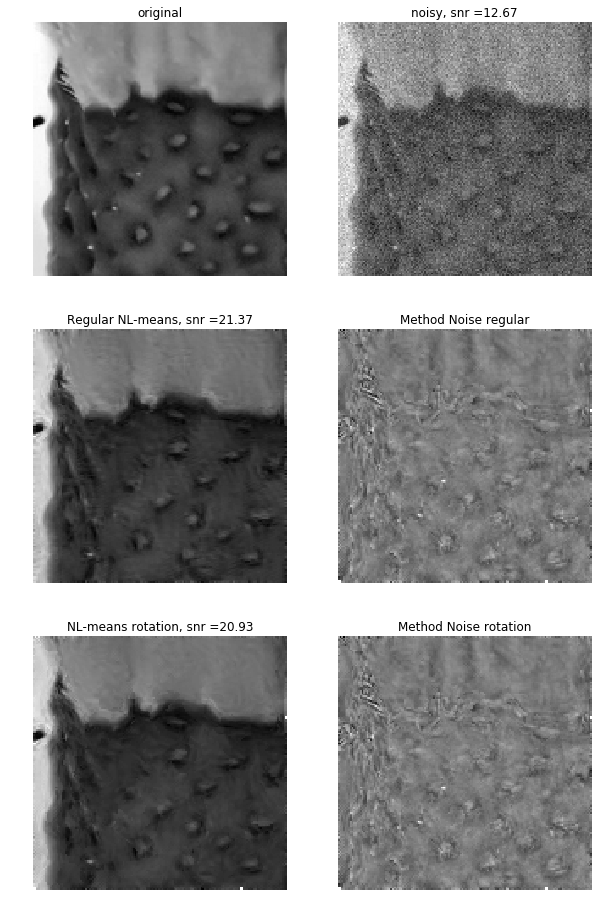

In [1190]:
R_rot2 = copy(np.nan_to_num(R_rot))

plt.figure(figsize = (10,16))
imageplot(f0, 'original', [3,2,1])
imageplot(f, 'noisy, snr =' + str(round(snr(f,f0),2)), [3,2,2])
#reg = NL_means(f, w, q, d, 0.02, rotate = False) #tau[np.argmax(SNR_regular)]
imageplot(R_reg, 'Regular NL-means, snr =' + str(round(snr(R_reg,f0),2)), [3, 2, 3])
imageplot(f0 - R_rot, 'Method Noise regular', [3, 2, 4])

#rot = NL_means(f, w, q, d, 0.02, rotate = True)
imageplot(R_rot, 'NL-means rotation, snr =' +  str(round(snr(R_rot2,f0),2)), [3, 2, 5])
imageplot(f0 - R_rot, 'Method Noise rotation', [3, 2, 6])

plt.savefig('compare outputs max h sigma 0_04 w=%d.jpg' %w)

In [1172]:
R_rot2 = copy(np.nan_to_num(R_rot))


### Test the noise value

0.001
0.016307692307692308


C:\Users\alien\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


0.031615384615384615
0.04692307692307693
0.062230769230769235
0.07753846153846154
0.09284615384615386
0.10815384615384616
0.12346153846153847
0.13876923076923078
0.15407692307692308
0.16938461538461538
0.1846923076923077
0.2


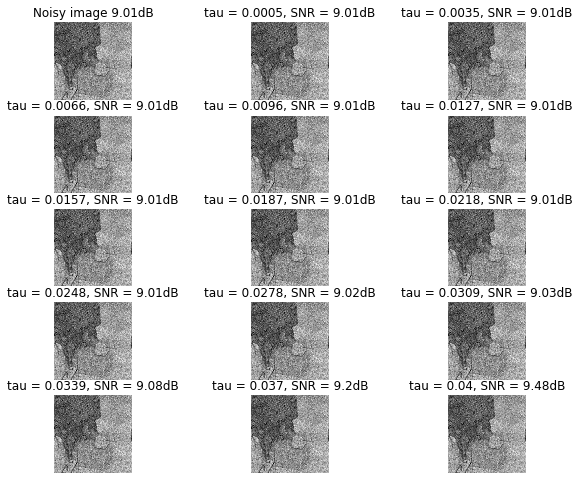

In [901]:
n = 150
q = 14 #patch window
d = 25 #dimensionnality reduction
c = [80,350]
tau = np.linspace(0.0005, 0.04, 14)
SNR_noise_level = []
all_w = 4

f0 = load_image("nt_toolbox/data/airport.jpg")
f0 = rescale(f0[c[0]-n//2:c[0]+n//2, c[1]-n//2:c[1]+n//2])
all_sigma = np.linspace(0.001, 0.2, 14)

plt.figure(figsize = (10,10))
for sigma in all_sigma:
    print(sigma)
    f = f0 + sigma*random.standard_normal(f0.shape) #noisy image
    imageplot(f, 'Noisy image ' + str(round(snr(f0, f),2)) + 'dB', [(len(all_sigma)+1)//3 +1, 3, 1])
    SNR_loc = []
    for i in range(len(tau)):
        imout_regular = NL_means(f, w, q, d, tau[i], rotate = False)
        err_regular = round(snr(f0, imout_regular),2)        
        SNR_loc.append(err_regular)
        imageplot(imout_regular, 'tau = ' + str(round(tau[i], 4)) +', SNR = ' + str(err_regular) + 'dB', [(len(tau)+1)//3 +1, 3, i+2])
    SNR_noise_level.append(SNR_loc)

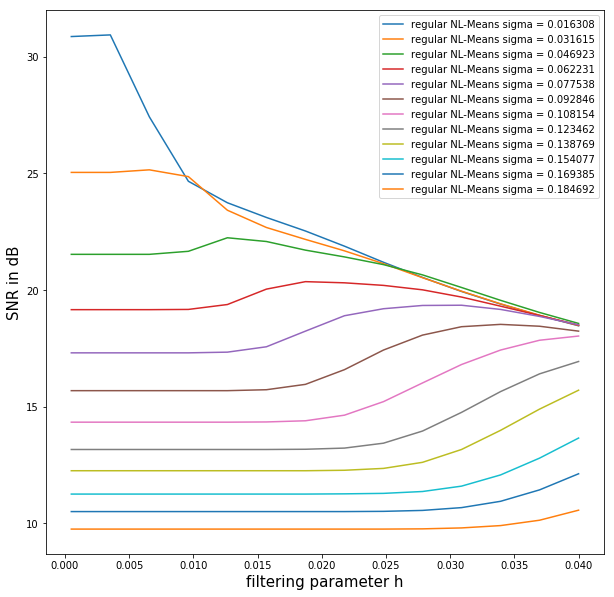

In [905]:
plt.figure(figsize = (10,10))

for i in range(1, len(all_sigma)-1):
    plt.plot(tau, SNR_noise_level[i], label = 'regular NL-Means sigma = %f' %(all_sigma[i]))
plt.xlabel('filtering parameter h', fontsize = 15)
plt.ylabel('SNR in dB', fontsize = 15)
plt.legend()
plt.savefig('compare SNR filtering parameter sigma 0_04 sigma_all airport.jpg')

### Test the window size

In [ ]:
n = 150
all_q = [4, 6, 10, 14, 18, 22, 28, 36, 48, 54, 60, 75] #14 #patch window
d = 25 #dimensionnality reduction
c = [80,350]
tau = np.linspace(0.0005, 0.07, 14)
SNR_window_size = []
w = 4

f0 = load_image("nt_toolbox/data/airport.jpg")
f0 = rescale(f0[c[0]-n//2:c[0]+n//2, c[1]-n//2:c[1]+n//2])
f = f0 + sigma*random.standard_normal(f0.shape) #noisy image
sigma = 0.04
imageplot(f, 'Noisy image ' + str(round(snr(f0, f),2)) + 'dB', [(len(tau)+1)//3 +1, 3, 1])
plt.figure(figsize = (10,10))
for q in all_q:
    print(q)
    SNR_loc = []
    for i in range(len(tau)):
        imout_regular = NL_means(f, w, q, d, tau[i], rotate = False)
        err_regular = round(snr(f0, imout_regular),2)        
        SNR_loc.append(err_regular)
        imageplot(imout_regular, 'tau = ' + str(round(tau[i], 4)) +', SNR = ' + str(err_regular) + 'dB', [(len(tau)+1)//3 +1, 3, i+2])
    SNR_window_size.append(SNR_loc)

4
6


C:\Users\alien\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


10
14
18
22
28
36
48


In [943]:
plt.figure(figsize = (10,10))

for i in range(len(all_q)):
    plt.plot(tau, SNR_window_size[i], label = 'regular NL-Means sigma = %f' %(all_q[i]))
plt.xlabel('filtering parameter h', fontsize = 15)
plt.ylabel('SNR in dB', fontsize = 15)
plt.legend()
plt.savefig('compare SNR filtering parameter sigma 0_04 all_q airport.jpg')

IndexError: list index out of range

[[115.09397587 178.52935511 178.73654103 ... 307.2743223  306.47123965
  307.17601755]
 [114.66502208 114.90880649 116.97015023 ... 307.97835332 307.16236195
  307.79035201]
 [114.86951012 115.11393487 117.24597733 ... 305.83948654 305.12898495
  305.39034526]
 ...
 [ 66.77735567  67.44334719  66.65992111 ... 210.1469185  215.86299885
  209.22782842]
 [ 66.07423457  66.75678431  66.05105076 ... 207.63640461 211.36460926
  205.59391458]
 [ 66.24092175  66.90577226  66.23333827 ... 206.20954575 208.58788759
  203.55349953]]


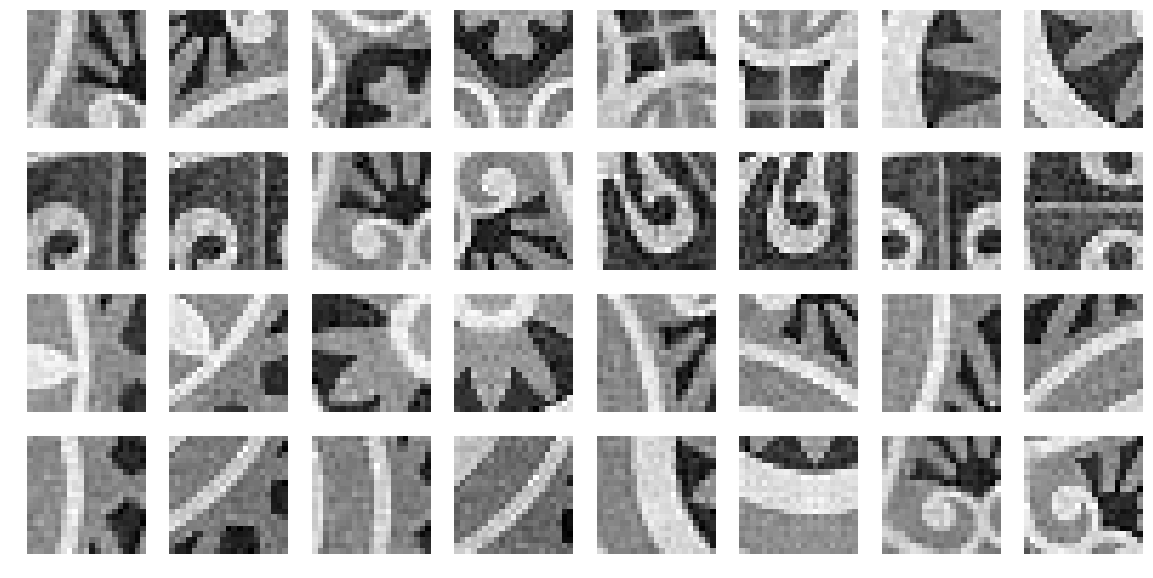

In [431]:
from numpy import random
w = 10
plt.figure(figsize = (20,10))
patches = generate_patches(f, w)
P = generate_patches_oriented(f, w, 36)


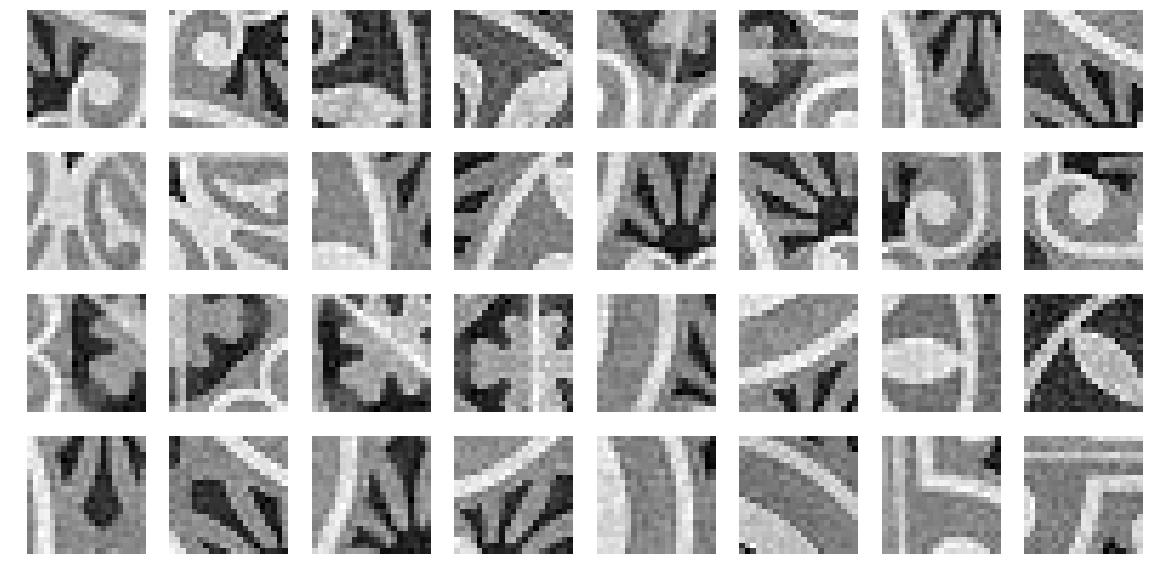

In [443]:
plt.figure(figsize = (20,10))

for i in range(16):
    x = random.randint(n)
    y = random.randint(n)
    imageplot(P[x, y], '', [4, 8, 2*i+1])
    imageplot(patches[x, y],'',[4, 8, 2*i +2])

#### Counting similar patches

In [1092]:
dmax = 1e-3
def count(P, w, q, d, tau, dmax):
    H, L = f.shape
    #P = generate_patches(f, w)
    D, V = PCA_patch(P)
    Dsc, w1 = dim_reduction(P, V, d)
    #apply NL-means
    [Y, X] = np.meshgrid(np.arange(0,H),np.arange(0,L))
    R = np.zeros([H,L])
    cnt = np.zeros([H, L])
    neighbors = []
    for k in range(H):
        for l in range(L):
            K, sel = window_search([k,l], tau, q, Dsc, w1, P)
            cnt[k,l] = np.count_nonzero(K>dmax)
            R[k,l] = NLval_0(K, sel)
    return R, cnt

####  SNR per location

In [1093]:
import pylab

def snr_per_loc(f0,P,w):
    norme = pylab.norm(f0)*((2*w+1)^2)/(n*n)
    P_original = generate_patches(f0, w)
    P_denoised = P

    [H, L, rm, rm] = np.shape(P_original)
    [Y, X] = np.meshgrid(np.arange(0,H),np.arange(0,L))
    PSNR = np.zeros([H,L])
    for k in range(H):
        for l in range(L):
            err =  20 * np.log10(norme / pylab.norm(P_original[k,l] - P_denoised[k,l]))
            PSNR[k,l] = err

    return PSNR

In [1103]:
def collect_variance(P):
    H, L = f.shape
    variances =  np.zeros((H, L))
    for k in range(H):
        for l in range(L):
            variances[k,l]=np.std(P[k,l]) #Inverse of the local variance
    return variances

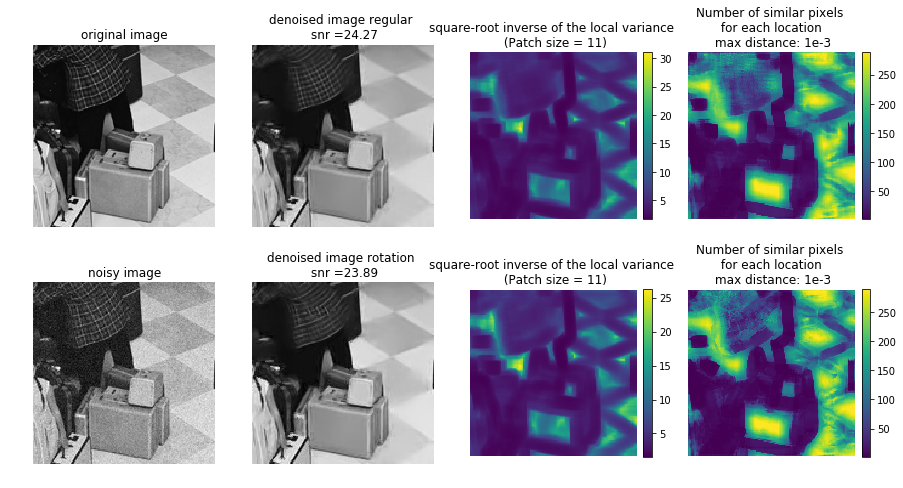

In [1106]:
n = 150
w = 5
w1 = 2*w + 1 #patch size
q = 8 #patch window
d = 25 #dimensionnality reduction
c = [80, 350]
tau = 0.02

f0 = load_image("nt_toolbox/data/airport.jpg")
f0 = rescale(f0[c[0]-n//2:c[0]+n//2, c[1]-n//2:c[1]+n//2])
sigma = .04 #noise level

f = f0 + sigma*random.standard_normal(f0.shape) #noisy image

P_reg = generate_patches(f, w)
u, Q_reg, sel_ireg = NL_means(f, w, q, d, tau,  rotate = False, blur = 1, N=100, i= i)
#u,a,b = NL_means(f, w, q, d, tau, P = P_reg, rotate = False, N = 100)

Pu = generate_patches(u, w)
PSNR_u = snr_per_loc(f0, Pu,w)
R, cnt_u = count(P_reg, w, q, d, tau, dmax)

P_rot = generate_patches_oriented(f, w, 100)
v, Q_rot, sel_irot = NL_means(f, w, q, d, tau,  rotate = True, blur = 1, N=100, i = i)

#v,a,b = NL_means(f, w, q, d, tau, P= P_rot, rotate = True)

Pv = generate_patches(v, w)
PSNR_v = snr_per_loc(f0, Pv,w)
R, cnt_v = count(P_rot, w, q, d, tau, dmax)

VARu = collect_variance(Pu)
VARv = collect_variance(Pv)


plt.figure(figsize = (15,8))

imageplot(f0, 'original image', [2,4,1])
imageplot(f, 'noisy image', [2,4,5])

imageplot(u, 'denoised image regular \n snr =' + str(round(snr(f0,u),2)), [2,4,2])
imageplot(v, 'denoised image rotation \n snr =' + str(round(snr(f0,v),2)), [2,4,6])

#imageplot(PSNR_u, 'SNR of each patch \n regular', [2, 4, 3], cmap = 'viridis', cbar = True)
#imageplot(PSNR_u, 'SNR of each patch \n rotation', [2, 4, 7], cmap = 'viridis', cbar = True)

imageplot(cnt_u, 'Number of similar pixels \n for each location \n max distance: 1e%d'%np.log10(dmax),
          [2,4,4], cmap = 'viridis', cbar = True )
imageplot(cnt_v, 'Number of similar pixels \n for each location \n max distance: 1e%d' %np.log10(dmax),
          [2,4,8], cmap = 'viridis', cbar = True )

imageplot(1/np.sqrt(VARu), 'square-root inverse of the local variance \n (Patch size = %d)' %w1,
          [2,4,3], cmap = 'viridis', cbar = True)
imageplot(1/np.sqrt(VARv), 'square-root inverse of the local variance \n (Patch size = %d)' %w1,
          [2,4,7], cmap = 'viridis', cbar = True)
plt.savefig('SNR_pair_rot_reg_patchsize%d.jpg'%w)

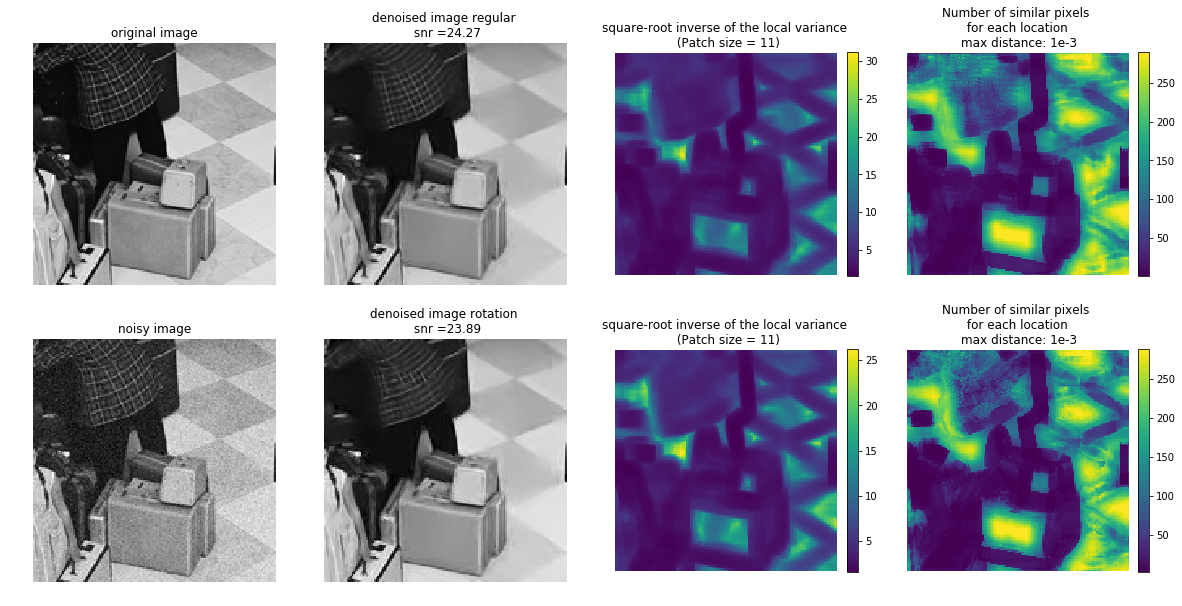

In [1107]:
plt.figure(figsize = (20,10))

imageplot(f0, 'original image', [2,4,1])
imageplot(f, 'noisy image', [2,4,5])

imageplot(u, 'denoised image regular \n snr =' + str(round(snr(f0,u),2)), [2,4,2])
imageplot(v, 'denoised image rotation \n snr =' + str(round(snr(f0,v),2)), [2,4,6])

#imageplot(PSNR_u, 'SNR of each patch \n regular', [2, 4, 3], cmap = 'viridis', cbar = True)
#imageplot(PSNR_u, 'SNR of each patch \n rotation', [2, 4, 7], cmap = 'viridis', cbar = True)

imageplot(cnt_u, 'Number of similar pixels \n for each location \n max distance: 1e%d'%np.log10(dmax),
          [2,4,4], cmap = 'viridis', cbar = True )
imageplot(cnt_v, 'Number of similar pixels \n for each location \n max distance: 1e%d' %np.log10(dmax),
          [2,4,8], cmap = 'viridis', cbar = True )

imageplot(1/np.sqrt(VARu), 'square-root inverse of the local variance \n (Patch size = %d)' %w1,
          [2,4,3], cmap = 'viridis', cbar = True)
imageplot(1/np.sqrt(VARv), 'square-root inverse of the local variance \n (Patch size = %d)' %w1,
          [2,4,7], cmap = 'viridis', cbar = True)
plt.savefig('SNR_pair_rot_reg_patchsize%d.jpg'%w)

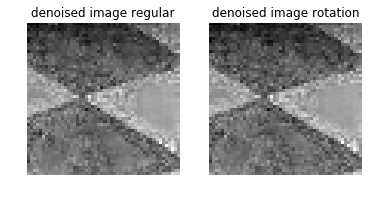

In [679]:

imageplot(u[0:50, 100:150], 'denoised image regular', [1,2,1])
imageplot(v[0:50, 100:150], 'denoised image rotation', [1,2,2])

In [650]:
type('False')

str

In [308]:
def assign_orientation_patch(P_orientation, P_magnitude, w, N):
    '''
    Assigns the principal orientation to a patch
    
    '''
    #Assigning angle to histogram bin
    orientation_bin = ((P_orientation+np.pi)*N/np.pi)//2
    #Initialisation
    [H, L] = P_orientation.shape
    histo = np.zeros((N, 1))
    histo_weight = np.zeros((N, 1))
    kern = gaussian_kernel(w)
    #Give more weight to patch's center pixels
    P_magnitude = P_magnitude * kern[:-1, :-1]
    #Generation of the histogram and weighted histogram
    for i in range(N):
        index_bin_i = orientation_bin == i
        histo[i] = np.count_nonzero(index_bin_i, (0,1))
        mag_copy = copy(P_magnitude)
        mag_copy[orientation_bin != i]=0
        histo_weight[i] = np.sum(mag_copy, axis = (0, 1))
    #smoothing by 6 circular convolutions
    for i in range(6):
        histo_weight = cconv(histo_weight, [1/3,1/3,1/3], 0)
    #extraction of the reference orientations
    theta = 0
    maxi = np.max(histo_weight)
    for i in range(N):
        h = histo_weight[i]
        h_plus = histo_weight[(i+1)%N] 
        h_minus = histo_weight[(i-1)%N]
        d = h == maxi
        theta = np.maximum((360*(i+1/2)/N + 180/N * ((h_minus - h_plus)/(h_minus - 2*h + h_plus)))*d, theta)

    return theta

In [808]:
n = 150
w = 3
w1 = 2*w + 1 #patch size
q = 14 #patch window
d = 25 #dimensionnality reduction
c = [75, 75]
tau = 0.015
SNR_rotate = []
SNR_regular = []


f0 = load_image("nt_toolbox/data/patch0.jpg")
f0 = rescale(f0[c[0]-n//2:c[0]+n//2, c[1]-n//2:c[1]+n//2])
sigma = .15 #noise level
f0 = f0 + sigma*random.standard_normal(f0.shape) #noisy image

ori = gradient_orientation(f0)
mag = gradient_magnitude(f0)

theta0 = assign_orientation_patch(ori, mag, 75, 72)

f1 = load_image("nt_toolbox/data/patch1.jpg")
f1 = rescale(f1[c[0]-n//2:c[0]+n//2, c[1]-n//2:c[1]+n//2])
f1 = f1 + sigma*random.standard_normal(f0.shape) #noisy image

ori = gradient_orientation(f1)
mag = gradient_magnitude(f1)

theta1 = assign_orientation_patch(ori, mag, 75, 72)

f2 = load_image("nt_toolbox/data/patch2.jpg")
f2 = rescale(f2[c[0]-n//2:c[0]+n//2, c[1]-n//2:c[1]+n//2])
f2 = f2 + sigma*random.standard_normal(f0.shape) #noisy image

ori = gradient_orientation(f2)
mag = gradient_magnitude(f2)

theta2 = assign_orientation_patch(ori, mag, 75, 72)

In [809]:
v = crop_center(scp.ndimage.interpolation.rotate(f0,-theta0, axes=(1, 0), reshape=False,
                                       output=None, order=3, mode='constant', cval=1, prefilter=True), 130, 130)
u = crop_center(scp.ndimage.interpolation.rotate(f1,-theta1, axes=(1, 0), reshape=False,
                                       output=None, order=3, mode='constant', cval=1, prefilter=True), 130, 130)
z = crop_center(scp.ndimage.interpolation.rotate(f2,-theta2, axes=(1, 0), reshape=False,
                                       output=None, order=3, mode='constant', cval=1, prefilter=True), 130, 130)

In [810]:
def assign_orientation_patch(P_orientation, P_magnitude, w, N):
    [H, L] = P_orientation.shape
    orientation_bin = ((P_orientation+np.pi)*N/np.pi)//2
    histo = np.zeros((N))
    histo_weight = np.zeros((N))
    kern = gaussian_kernel(w, sigma = 10)
    P_magnitude = P_magnitude * kern[:-1,:-1]
    for i in range(N):
        index_bin_i = orientation_bin == i
        histo[i] = np.count_nonzero(index_bin_i, (0,1))
        mag_copy = copy(P_magnitude)
        mag_copy[orientation_bin != i]=0
        histo_weight[i] = np.sum(mag_copy, axis = (0, 1))
        princip_ori = np.argmax(histo_weight, axis = 0)
    return princip_ori*360/N

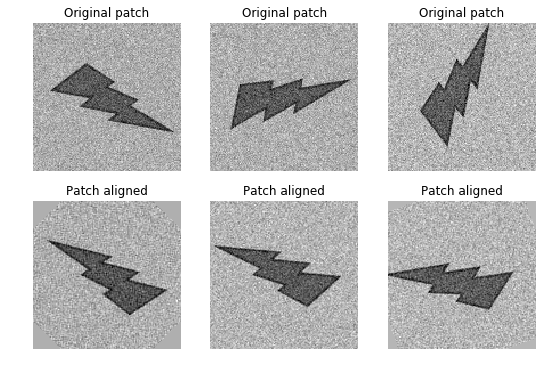

In [811]:
plt.figure(figsize = (9,6))
imageplot(f0[10:140, 10: 140], 'Original patch', [2,3,1])
imageplot(u, 'Patch aligned', [2, 3, 4])

imageplot(f1[10:140, 10: 140], 'Original patch', [2,3,2])
imageplot(v, 'Patch aligned', [2, 3, 5])

imageplot(f2[10:140, 10: 140], 'Original patch', [2,3,3])
imageplot(z, 'Patch aligned', [2, 3, 6])

In [783]:
from numpy import random

plt.figure(figsize = (5,5))
P = generate_patches()
for i in range(16):
    x = random.randint(n)
    y = random.randint(n)
    imageplot(P[x, y], '', [4, 4, i+1])

TypeError: generate_patches() missing 2 required positional arguments: 'f' and 'w'

In [339]:
np.min(np.min(f))

0.0

In [299]:
f0 = load_image("nt_toolbox/data/patch1.jpg")
w = 3
orientation = gradient_orientation(f0)
magnitude = gradient_magnitude(f0)

c = assign_orientation_patch(orientation, magnitude, 75,360)

In [300]:
u = scp.ndimage.interpolation.rotate(f0,c, axes=(1, 0), reshape=True,
                                       output=None, order=3, mode='constant', cval=0.0, prefilter=True)

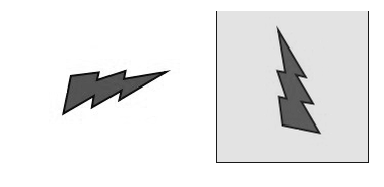

In [301]:
imageplot(f0, '', [1, 2, 1])
imageplot(u, '', [1,2,2])

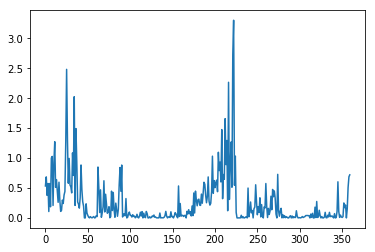

In [822]:
plt.plot(b)

In [824]:
c = 25

In [792]:
def assign_orientation(P_orientation, P_magnitude, w, N):
    [H, L, w1, w1] = P_orientation.shape
    orientation_bin = ((P_orientation+np.pi)*N/np.pi)//2
    histo = np.zeros((H, L, N))
    histo_weight = np.zeros((H, L, N))
    kern = gaussian_kernel(w)
    P_magnitude = P_magnitude * kern
    for i in range(N):
        index_bin_i = orientation_bin == i
        histo[:,:,i] = np.count_nonzero(index_bin_i, (2,3))
        mag_copy = copy(P_magnitude)
        mag_copy[orientation_bin != i]=0
        histo_weight[:,:,i] = np.sum(mag_copy, axis = (2, 3))
        princip_ori = np.argmax(histo_weight, axis = 2)
    return princip_ori*360/N
    
    

In [182]:
def ori_mag(f, w):
    ori = gradient_orientation(f)
    mag = gradient_magnitude(f)
    w_aug = int(w*1.7)

    (H, L) = f.shape
    [X,Y,dX,dY] = np.meshgrid(np.arange(1,L+1),np.arange(1,H+1),np.arange(-w_aug,w_aug+1),np.arange(-w_aug,w_aug+1))
    X = X + dX
    Y = Y + dY

    #boundary conditions
    X[X < 1] = 2-X[X < 1] 
    Y[Y < 1] = 2-Y[Y < 1]
    X[X > H] = 2*H-X[X > H]
    Y[Y > L] = 2*L-Y[Y > L]

    #patch extractor operator
    I = (X-1) + (Y-1)*H
    for i in range(H//w_aug):
        for j in range(L//w_aug):
            I[i,j] = np.transpose(I[i,j])

    def patch_orientation(f):
        return np.ravel(ori)[I]
    def patch_magnitude(f):
        return np.ravel(mag)[I]
    P_orientation = patch_orientation(f)
    P_magnitude = patch_magnitude(f)
    
    return P_magnitude, P_orientation


In [444]:
w = 3
P_magnitude, P_orientation = ori_mag(f, w)
N = 36
def assign_orientation(P_orientation, P_magnitude, w, N):
    #Assigning angle to histogram bin
    orientation_bin = ((P_orientation+np.pi)*N/np.pi)//2
    #Initialisation
    [H, L, w1, w1] = P_orientation.shape
    histo = np.zeros((H, L, N))
    histo_weight = np.zeros((H, L, N))
    kern = gaussian_kernel(w1//2)
    #Give more weight to patch's center pixels
    P_magnitude = P_magnitude * kern
    #Generation of the histogram and weighted histogram
    for i in range(N):
        index_bin_i = orientation_bin == i
        histo[:,:,i] = np.count_nonzero(index_bin_i, (2,3))
        mag_copy = copy(P_magnitude)
        mag_copy[orientation_bin != i]=0
        histo_weight[:,:,i] = np.sum(mag_copy, axis = (2, 3))
    #smoothing by 6 circular convolutions
    for i in range(6):
        histo_weight = cconv(histo_weight, [1/3,1/3,1/3], 2)
    #extraction of the reference orientations
    theta = np.zeros((n,n, N))
    maxi = np.max(histo_weight, 2)
    for i in range(N):
        h = histo_weight[:,:,i]
        h_plus = histo_weight[:,:,(i+1)%N] 
        h_minus = histo_weight[:,:,(i-1)%N]
        a = h > h_plus
        b = h > h_minus
        c = h > 0.8 * np.max(histo_weight, 2)
        d = a*b*c
        d = h == maxi
        theta[:,:,i] = np.maximum((360*(i+1/2)/N + 180/N * ((h_minus - h_plus)/(h_minus - 2*h + h_plus)))*d, theta)
        
        
    return theta


In [153]:
theta = np.zeros(histo_weight.shape)

for i in range(N):
    h = histo_weight[:,:,i]
    #print(h[20, 30])
    h_plus = histo_weight[:,:,(i+1)%N] 
    #print(h_plus[20, 30])
    h_minus = histo_weight[:,:,(i-1)%N]
    #print(h_minus[20, 30])
    a = h > h_plus
    b = h > h_minus
    c = h > 0.8 * np.max(histo_weight, 2)
    d = a*b*c
    print(d[20,30])

    theta[:,:,i] = (360*(i+1/2)/N + 180/N * ((h_minus - h_plus)/(h_minus - 2*h + h_plus)))*d
    print(theta[20,30,i])
print(theta[20, 30])

False
-0.0
False
0.0
False
0.0
False
0.0
False
0.0
False
0.0
False
0.0
False
0.0
False
0.0
False
0.0
False
0.0
False
0.0
False
0.0
False
0.0
False
0.0
False
0.0
False
0.0
False
0.0
False
0.0
False
0.0
False
0.0
False
0.0
False
0.0
False
0.0
False
0.0
False
0.0
False
0.0
False
0.0
False
0.0
True
299.447972730736
False
0.0
False
0.0
False
0.0
False
0.0
False
0.0
False
0.0
[ -0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.         299.44797273
   0.           0.           0.           0.           0.
   0.        ]


In [167]:
theta = np.zeros((n,n))
maxi = np.max(histo_weight, 2)
for i in range(N):
    h = histo_weight[:,:,i]
    h_plus = histo_weight[:,:,(i+1)%N] 
    h_minus = histo_weight[:,:,(i-1)%N]
    d = h == maxi

    theta = np.maximum((360*(i+1/2)/N + 180/N * ((h_minus - h_plus)/(h_minus - 2*h + h_plus)))*d, theta)
theta


array([[212.14753306, 211.96236015,  66.98232553, ..., 177.78049558,
        175.90443783,  95.07964559],
       [213.38120851, 213.1629676 ,  65.10150237, ..., 177.64158106,
        175.85785307,  94.12974466],
       [ 56.69710264,  57.89784704,  60.91376953, ..., 177.15841559,
         91.99775307,  92.18780515],
       ...,
       [271.0162868 , 270.89800621, 270.63360552, ...,   0.3819535 ,
         85.04519515,  84.99492834],
       [273.32996508, 273.17369024, 357.02756473, ...,   0.37938661,
         83.40101775,  83.33928891],
       [274.45925557, 353.67635279, 356.81625726, ...,   0.37444331,
        359.41887764,  82.49954281]])

In [194]:
P = generate_patches(f, 3)
princip_ori = theta
i = 5
j = 3
crop_center(scp.ndimage.interpolation.rotate(
                P[i,j,:,:],princip_ori[i,j], axes=(1, 0), reshape=True,
                output=None, order=3, mode='constant', cval=0.0, prefilter=True),
                                              2*w + 1, 2*w + 1)

array([[0.        , 1.0445343 , 1.01019575, 1.04732431, 0.21082221,
        0.        , 0.        ],
       [0.98050136, 0.99994015, 0.97414287, 1.09208083, 0.85002073,
        0.26446844, 0.        ],
       [0.95738592, 0.94093449, 0.98767444, 1.03345761, 1.06626285,
        1.15565028, 0.45653587],
       [1.00496212, 0.90936864, 0.93650413, 1.01759362, 0.96209985,
        0.99104344, 0.        ],
       [0.97064747, 1.05278468, 1.04092266, 1.01873259, 1.03051069,
        0.92500395, 0.        ],
       [0.        , 1.01105814, 1.02357612, 0.92355585, 0.98915316,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.97751357, 0.        ,
        0.        , 0.        ]])